In [1]:
import sys
sys.path.append('../')

import pandas as pd
# import modin.pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba
import joblib 


In [2]:
pd.options.display.max_rows=500
pd.options.display.max_columns=500
%load_ext autoreload
%autoreload 2


In [3]:
all_df = pd.read_pickle('../data/ml-ta-all-data-201908262001.pkl.gz', compression='gzip')
print('Data loaded')
print(all_df.shape)

Data loaded
(1079523, 1227)


In [4]:
from optimise_dataframe import optimise_df

all_df = optimise_df(all_df)
train_df = all_df

In [5]:
del all_df

In [7]:
target_col = 'target'

numeric_cols = []
category_cols = []
boolean_cols = []

for col in train_df.columns:
    if train_df[col].dtype.name == 'object':
        print(col, train_df[col].dtype.name)
    elif train_df[col].dtype.name == 'category' and col != target_col:
        category_cols.append(col)
        print('category:', col)
    elif train_df[col].dtype.name == 'int8' and col != target_col:
        boolean_cols.append(col)
    elif train_df[col].dtype.name != 'int8' and col != target_col:
        numeric_cols.append(col)
    elif col == target_col:
        print('--- Target', col, train_df[col].dtype.name)

# print(numeric_cols)
joblib.dump(numeric_cols, '../models/numeric_cols.joblib.z') 
joblib.dump(category_cols, '../models/category_cols.joblib.z') 
joblib.dump(boolean_cols, '../models/boolean_cols.joblib.z') 


category: one_week_bollinger_prediction
category: two_week_bollinger_prediction
category: four_week_bollinger_prediction
category: eight_week_bollinger_prediction
category: twelve_week_bollinger_prediction
category: twenty_six_week_bollinger_prediction
category: fifty_two_week_bollinger_prediction
category: one_week_bollinger_type
category: two_week_bollinger_type
category: four_week_bollinger_type
category: eight_week_bollinger_type
category: twelve_week_bollinger_type
category: twenty_six_week_bollinger_type
category: fifty_two_week_bollinger_type
category: symbol
category: GICSSector
category: GICSIndustryGroup
category: GICSIndustry
--- Target target float32


['../models/boolean_cols.joblib.z']

In [8]:
# Split data for train / test 
groups = train_df.groupby('symbol')
train_df['week_starting'] = train_df.index

train_data = pd.DataFrame(groups.apply(lambda x: x.sample(frac=0.9)))
test_data = train_df.set_index(['symbol', 'week_starting']).drop(train_data.index)
test_data['symbol'] = test_data.index.get_level_values(0)

print(train_df.shape)
print(train_data.shape)
print(test_data.shape)


(1079523, 1228)
(971418, 1228)
(108105, 1227)


In [9]:
del train_df

In [10]:
# Train pre-processor
from sklearn import preprocessing

# Scale all numeric columns excluding target col
print('Scaling', len(numeric_cols), 'of', train_data.shape[1], 'cols')

scaler = preprocessing.MinMaxScaler()

# Fill any infinities, -infinites, NaNs which will cause scaler to fail
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data[numeric_cols] = train_data[numeric_cols].fillna(0)

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data[numeric_cols] = test_data[numeric_cols].fillna(0)

# Transform data and fill any NAs
scaler.fit(train_data[numeric_cols])
train_data[numeric_cols] = scaler.transform(train_data[numeric_cols])
train_data[numeric_cols] = train_data[numeric_cols].fillna(0)

test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])
test_data[numeric_cols] = test_data[numeric_cols].fillna(0)


joblib.dump(scaler, '../models/scaler.joblib.z') 


Scaling 1007 of 1228 cols


/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


['../models/scaler.joblib.z']

In [ ]:
# Execute pre-processor
from sklearn import preprocessing

# Scale all numeric columns excluding target col
print('Scaling', len(numeric_cols), 'of', train_data.shape[1], 'cols')

scaler = joblib.load('../models/scaler.joblib.z') 

# Fill any infinities, -infinites, NaNs which will cause scaler to fail
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data[numeric_cols] = train_data[numeric_cols].fillna(0)

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data[numeric_cols] = test_data[numeric_cols].fillna(0)

# Transform data and fill any NAs
train_data[numeric_cols] = scaler.transform(train_data[numeric_cols])
train_data[numeric_cols] = train_data[numeric_cols].fillna(0)

test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])
test_data[numeric_cols] = test_data[numeric_cols].fillna(0)



In [11]:
train_data[numeric_cols].head(100)

lastTradePriceOnly  adjustedPrice    volume  \
symbol week_starting                                                
14D    2018-10-07               0.000971       0.020207  0.001267   
       2019-01-27               0.000846       0.020204  0.000418   
       2019-02-10               0.001082       0.020211  0.000640   
       2018-12-30               0.000804       0.020203  0.000172   
       2018-10-14               0.000846       0.020204  0.001382   
       2018-12-09               0.000707       0.020200  0.000215   
       2019-01-13               0.000804       0.020203  0.000146   
       2018-12-23               0.000818       0.020203  0.000204   
       2019-01-20               0.000790       0.020202  0.000148   
       2018-12-16               0.000735       0.020201  0.000400   
       2018-12-02               0.000735       0.020201  0.000176   
       2018-10-28               0.000818       0.020203  0.000446   
       2018-11-25               0.000735       0.020201  0.000242   
       2018-11-11               0.000790       0.020202  0.000295   
       2019-02-24               0.001012       0.020209  0.000273   
       2018-09-30               0.000957       0.020207  0.005713   
       2019-02-17               0.001012       0.020209  0.000484   
       2018-11-18               0.000735       0.020201  0.000401   
       2018-09-23               0.001040       0.020210  0.018283   
       2018-11-04               0.000804       0.020203  0.000349   
       2019-02-03               0.000908       0.020206  0.000326   
       2018-10-21               0.000860       0.020204  0.000967   
1AD    2018-12-30               0.000638       0.020198  0.000000   
       2018-08-19               0.000804       0.020203  0.000035   
       2018-08-12               0.000832       0.020204  0.000024   
       2018-11-04               0.000756       0.020202  0.000000   
       2018-04-08               0.000818       0.020207  0.000000   
       2016-11-06               0.000527       0.020194  0.000000   
       2017-12-24               0.000673       0.020198  0.000307   
       2017-06-04               0.000790       0.020204  0.000050   
       2016-12-04               0.000582       0.020193  0.000000   
       2018-08-05               0.000825       0.020204  0.000013   
       2017-07-02               0.000770       0.020202  0.000044   
       2017-04-16               0.000700       0.020199  0.000635   
       2017-01-15               0.000562       0.020196  0.000000   
       2017-08-27               0.000679       0.020198  0.000000   
       2018-07-29               0.000832       0.020203  0.000016   
       2018-12-02               0.000721       0.020200  0.000011   
       2017-03-19               0.000603       0.020196  0.000057   
       2016-10-30               0.000562       0.020195  0.000151   
       2018-09-30               0.000763       0.020201  0.000005   
       2017-01-01               0.000499       0.020194  0.000058   
       2017-06-18               0.000693       0.020199  0.000027   
       2017-11-12               0.000596       0.020197  0.000000   
       2017-12-31               0.000693       0.020199  0.000000   
       2018-07-08               0.000971       0.020208  0.000115   
       2016-11-20               0.000569       0.020198  0.000000   
       2017-02-19               0.000569       0.020196  0.000000   
       2019-01-13               0.000000       0.020198  0.000000   
       2017-09-17               0.000000       0.020197  0.000000   
       2017-10-01               0.000624       0.020197  0.000000   
       2017-11-26               0.000000       0.020199  0.000000   
       2017-07-16               0.000693       0.020199  0.000000   
       2018-04-15               0.000860       0.020203  0.000000   
       2016-10-16               0.000596       0.020197  0.000067   
       2019-01-06               0.000666       0.020198  0.000000   
       2018-07-15   

In [12]:
test_data[numeric_cols].head(100)

lastTradePriceOnly  adjustedPrice        volume  \
symbol week_starting                                                    
ISG    2008-01-06               0.042682       0.021337  4.341431e-07   
       2008-02-17               0.000000       0.021160  0.000000e+00   
       2008-06-15               0.037607       0.021223  8.682862e-07   
       2008-08-24               0.036081       0.021151  0.000000e+00   
       2008-10-05               0.033668       0.021106  0.000000e+00   
       2008-10-19               0.033987       0.021045  0.000000e+00   
       2008-11-16               0.030132       0.020992  1.157715e-06   
       2009-04-12               0.026791       0.020894  8.827577e-06   
       2009-05-03               0.027262       0.020913  1.447144e-05   
       2009-07-26               0.033502       0.021081  2.894287e-07   
       2009-12-06               0.034667       0.021112  0.000000e+00   
       2010-01-03               0.035748       0.021161  0.000000e+00   
       2010-02-14               0.034001       0.021098  0.000000e+00   
       2010-08-01               0.000000       0.021188  0.000000e+00   
       2010-08-22               0.037412       0.021187  5.788575e-07   
       2010-10-24               0.038744       0.021223  0.000000e+00   
       2010-11-28               0.038466       0.021215  2.894287e-06   
       2011-01-23               0.038771       0.021223  2.315430e-06   
       2011-03-13               0.037010       0.021181  0.000000e+00   
       2011-05-01               0.036636       0.021173  0.000000e+00   
       2011-07-17               0.035596       0.021139  0.000000e+00   
       2011-10-02               0.031977       0.021043  0.000000e+00   
       2011-11-20               0.032254       0.021047  0.000000e+00   
       2012-03-25               0.033710       0.021087  0.000000e+00   
       2012-06-17               0.032781       0.021057  0.000000e+00   
       2012-07-29               0.034390       0.021118  2.026001e-06   
       2012-09-09               0.035388       0.021146  8.104005e-06   
       2012-10-21               0.036497       0.021176  0.000000e+00   
       2012-11-04               0.035638       0.021152  5.788575e-07   
       2012-11-11               0.035152       0.021141  0.000000e+00   
       2012-12-30               0.036414       0.021193  0.000000e+00   
       2013-06-16               0.038480       0.021266  2.894287e-07   
       2013-08-18               0.040380       0.021348  1.157715e-06   
       2014-01-05               0.000000       0.021344  0.000000e+00   
       2014-01-19               0.040061       0.021345  8.393433e-06   
       2014-05-04               0.040366       0.021345  0.000000e+00   
       2014-06-22               0.041018       0.021374  0.000000e+00   
       2014-08-10               0.041517       0.021396  0.000000e+00   
       2014-08-17               0.041434       0.021395  1.447144e-06   
       2014-10-05               0.042072       0.021420  2.894287e-06   
       2015-04-05               0.046648       0.021563  2.749573e-06   
       2015-04-19               0.048229       0.021606  6.656861e-06   
       2015-10-11               0.041295       0.021410  0.000000e+00   
       2016-05-15               0.038855       0.021367  0.000000e+00   
       2016-09-04               0.038993       0.021371  0.000000e+00   
       2016-11-20               0.074395       0.022463  0.000000e+00   
       2016-12-25               0.080288       0.022545  2.026001e-06   
       2017-01-15               0.079290       0.022577  8.682862e-07   
       2017-03-26               0.081620       0.022645  1.736572e-06   
       2017-09-03               0.087139       0.022792  0.000000e+00   
       2017-09-24               0.085197       0.022773  4.659803e-07   
       2018-01-07               0.094793       0.023042  0.000000e+00   
       2018-01-14               0.095597       0.023089  0.000000e+00   
       

In [13]:
def one_hot_encode_field(df, column_name, categories):
    new_cols = pd.get_dummies(df[column_name])
    new_cols = new_cols.astype('int8', errors='ignore')

    new_cols.T.reindex(categories).T.fillna(0)
    
    name_map = {}
    # rename the categories
    for val in categories:
        name_map[val] = val

    new_cols.rename(name_map, axis=1, inplace=True)
    
    # Remove the original column
    df.drop([column_name], axis=1, inplace=True)
    
    # Return df with new cols 
    return pd.concat([df, new_cols], axis=1)



In [14]:
from sklearn.preprocessing import LabelEncoder

def prep_class_index(df, column_name, categories):
    # Create 
    val_map = {}
    for i in range(len(categories)):
        val_map[categories[i]] = i
        
    print(val_map)
    df['class_index'] = df[column_name].map(val_map).values
    
    # Return df with new target index col
    return df


In [15]:
bins = [-99.07692719, -13.13461361, -3.00000238, 0.,9.25964718, 1493.]
bin_names = ['strong_sell', 'sell', 'hold', 'buy', 'strong_buy']


In [16]:
# prep data for training with one hot encoding
train_data['class'] = pd.cut(train_data['target'], bins=bins,labels=bin_names)
train_data = prep_class_index(train_data, 'class', bin_names)
train_data = one_hot_encode_field(train_data, 'class', bin_names)


test_data['class'] = pd.cut(test_data['target'], bins=bins,labels=bin_names)
test_data = prep_class_index(test_data, 'class', bin_names)
test_data = one_hot_encode_field(test_data, 'class', bin_names)


{'strong_sell': 0, 'sell': 1, 'hold': 2, 'buy': 3, 'strong_buy': 4}
{'strong_sell': 0, 'sell': 1, 'hold': 2, 'buy': 3, 'strong_buy': 4}


In [70]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras import optimizers, initializers
# from LAMB import LAMB
# from keras_lamb import LAMBOptimizer


# Determine unique vals for each category
col_vals_dict = {c: list(train_data[c].append(test_data[c]).unique()) for c in category_cols}

embed_cols = []
for c in category_cols:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions

        
# Build embedding network for category cols
inputs = []
embeddings = []

initalizer = initializers.TruncatedNormal(stddev=0.00001, seed=1975) # stddev=0.00002, seed=1975)
print('Initializer:', initalizer)

for c in embed_cols:
    embedding_input = Input(shape=(1,))
    vocab_size = len(col_vals_dict[c]) + 1
    embedding_size = int(min(np.ceil(vocab_size/2), 50))
    embedding = Embedding(vocab_size, embedding_size, input_length=1)(embedding_input)
    embedding = Reshape(target_shape=(embedding_size,))(embedding)
    print('Create embedding', c, col_vals_dict[c])
    print('Embedding size', embedding_size)
    print('Vocab size', vocab_size)
    inputs.append(embedding_input)
    embeddings.append(embedding)
    
# Add embedding for boolean cols
# input_boolean = Input(shape=(len(boolean_cols),))
# embedding_boolean = Dense(len(boolean_cols))(input_boolean) 
# inputs.append(input_boolean)
# embeddings.append(embedding_boolean)
# print('Create boolean embedding')
# print('Input shape', (len(boolean_cols),))

# Add embedding for numeric cols
input_numeric = Input(shape=(len(numeric_cols),))
embedding_numeric = Dense(len(numeric_cols))(input_numeric) 
inputs.append(input_numeric)
embeddings.append(embedding_numeric)
print('Create numeric embedding')
print('Input shape', (len(numeric_cols),))


# Build model
x = Concatenate()(embeddings)
x = Dense(1000, activation='relu', kernel_initializer=initalizer)(x)
x = Dropout(.4)(x)
x = Dense(500, activation='relu', kernel_initializer=initalizer, name='embedding_output')(x)
x = Dropout(.4)(x)
x = Dense(200, activation='relu', kernel_initializer=initalizer, name='int_layer')(x)
x = Dropout(.1)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs, output)
                             
model.summary()

model.compile(loss='kullback_leibler_divergence', optimizer=optimizers.Adamax(learning_rate=0.006), metrics=['accuracy'])

intermediate_model = Model(inputs=model.input, outputs=model.get_layer('int_layer').output)

embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding_output').output)


one_week_bollinger_prediction: 3 values
two_week_bollinger_prediction: 3 values
four_week_bollinger_prediction: 3 values
eight_week_bollinger_prediction: 3 values
twelve_week_bollinger_prediction: 3 values
twenty_six_week_bollinger_prediction: 3 values
fifty_two_week_bollinger_prediction: 3 values
one_week_bollinger_type: 3 values
two_week_bollinger_type: 3 values
four_week_bollinger_type: 3 values
eight_week_bollinger_type: 3 values
twelve_week_bollinger_type: 3 values
twenty_six_week_bollinger_type: 3 values
fifty_two_week_bollinger_type: 3 values
symbol: 2632 values
GICSSector: 13 values
GICSIndustryGroup: 26 values
GICSIndustry: 69 values
Initializer: <keras.initializers.TruncatedNormal object at 0x1675fc898>
Create embedding one_week_bollinger_prediction ['Steady', 'Rising', 'Falling']
Embedding size 2
Vocab size 4
Create embedding two_week_bollinger_prediction ['Steady', 'Falling', 'Rising']
Embedding size 2
Vocab size 4
Create embedding four_week_bollinger_prediction ['Steady', 

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_196 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_197 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_198 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_199 (InputLayer)          (None, 1)            0                                            
___________________________________________________________________________________________

In [53]:
# Prep data for model

input_list_train = []
input_list_test = []
category_val_maps = {}

# the cols to be embedded: rescaling to range [0, # values)
for c in category_cols:
    print('Processing', c)
    # Get full set of possible vals from complete data-set
    raw_vals = np.unique(train_data[c].append(test_data[c]))
    val_map = {}
    for i in range(len(raw_vals)):
        val_map[raw_vals[i]] = i       
    category_val_maps[c] = val_map
    input_list_train.append(train_data[c].map(val_map).values)

#the boolean columns
# print('Processing boolean cols')
# print(train_data[boolean_cols].shape)
# input_list_train.append(train_data[boolean_cols].values)


#the numeric columns
print('Processing numeric cols')
print(train_data[numeric_cols].shape)
input_list_train.append(train_data[numeric_cols].values)

print('Train X len', len(input_list_train))
print('Train X nulls', train_data[category_cols].isnull().any().sum())

# the cols to be embedded: rescaling to range [0, # values)
for c in category_cols:
    print('Processing', c)
    val_map = category_val_maps[c]
    input_list_test.append(test_data[c].map(val_map).values)

#the boolean columns
# print('Processing boolean cols')
# print(test_data[boolean_cols].shape)
# input_list_test.append(test_data[boolean_cols].values)


#the numeric columns
print('Processing numeric cols')
print(test_data[numeric_cols].shape)
input_list_test.append(test_data[numeric_cols].values)
    

print('Test X len', len(input_list_test))
print('Test X nulls', test_data[category_cols].isnull().any().sum())

joblib.dump(category_val_maps, '../models/embedding_category_val_maps.joblib.z') 
joblib.dump(input_list_train, '../data/embedding_input_list_train.joblib.z') 
joblib.dump(input_list_test, '../data/embedding_input_list_test.joblib.z') 


Processing one_week_bollinger_prediction
Processing two_week_bollinger_prediction
Processing four_week_bollinger_prediction
Processing eight_week_bollinger_prediction
Processing twelve_week_bollinger_prediction
Processing twenty_six_week_bollinger_prediction
Processing fifty_two_week_bollinger_prediction
Processing one_week_bollinger_type
Processing two_week_bollinger_type
Processing four_week_bollinger_type
Processing eight_week_bollinger_type
Processing twelve_week_bollinger_type
Processing twenty_six_week_bollinger_type
Processing fifty_two_week_bollinger_type
Processing symbol
Processing GICSSector
Processing GICSIndustryGroup
Processing GICSIndustry
Processing numeric cols
(971418, 1007)
Train X len 19
Train X nulls 0
Processing one_week_bollinger_prediction
Processing two_week_bollinger_prediction
Processing four_week_bollinger_prediction
Processing eight_week_bollinger_prediction
Processing twelve_week_bollinger_prediction
Processing twenty_six_week_bollinger_prediction
Processi

['../data/embedding_input_list_test.joblib.z']

In [19]:
# Set y values
y_train = train_data[bin_names].values
print('Train y shape', y_train.shape)
print('Train y nulls', train_data[bin_names].isnull().any().sum())

y_test = test_data[bin_names].values
print('Test y shape', y_test.shape)
print('Test y nulls', test_data[bin_names].isnull().any().sum())




Train y shape (971418, 5)
Train y nulls 0
Test y shape (108105, 5)
Test y nulls 0


In [ ]:
# Direct load training data

input_list_train = joblib.load('../data/embedding_input_list_train.joblib.z') 
input_list_test = joblib.load('../data/embedding_input_list_test.joblib.z') 
y_train = joblib.load('../data/embedding_y_train.joblib.z') 
y_test = joblib.load('../data/embedding_y_test.joblib.z') 


In [ ]:
# Directly load model
from keras.models import Model, load_model

model = load_model('../models/embedding_weekly.h5')

intermediate_model = Model(inputs=model.input, outputs=model.get_layer('int_layer').output)


In [71]:
# Train model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

print('Initializer:', initalizer)

checkpointer = ModelCheckpoint('../models/embedding_weekly.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-6, verbose=1)

model.fit(input_list_train, 
          y_train, 
          validation_data=(input_list_test, y_test), 
          epochs=2000,  
          batch_size=2048, 
          verbose=1, 
          callbacks=[reduce_lr, checkpointer, early_stop]
         )

# model.save('../models/embedding_weekly_1000_with_boolean.h5') 

# 500, 200, 100 lr 0.004 => epoch 60: loss: 1.2622, accuracy: 0.4701, num lr reductions: 0
# 1000, 500, 200 lr 0.006 => epoch 60: loss: 1.3076, accuracy: 0.4484, num lr reductions: 0
# 1000, 500, 200 lr 0.006 => epoch 1000: loss: 1.0373 , accuracy: 0.5743, num lr reductions: max
#     - 10: val_loss: 1.3629 - val_accuracy: 0.4236
#     - 50: val_loss: 1.3075 - val_accuracy: 0.4518
#     - 100: val_loss: 1.3030 - val_accuracy: 0.4538
#     - 500: val_loss: 1.3004 - val_accuracy: 0.4550
#     - 1000: val_loss: 1.2990 - val_accuracy: 0.4566
# 1000, 500, 200 lr 0.006 => epoch 500, (dropout: 0.4, 0.4, 0.1) batch: 1024 => accuracy: 0.6278 
# 1000, 500, 200 lr 0.006 => epoch 1000, (dropout: 0.5, 0.5, 0.2) batch: 2048 => accuracy: 0.6111928217936266 (test set)

# Added boolean cols:
# 1000, 500, 200 lr 0.006 => epoch 2000, (dropout: 0.5, 0.5, 0.5) batch: 4096 => accuracy: 0.6084454928079183 (test set)
# 1200, 600, 250 lr 0.006 => epoch 2000, (dropout: 0.5, 0.5, 0.5) batch: 2048 => accuracy: 0.604310623930438 (test set) 0.6776969337607498 (train set)
# Remove boolean cols (same datatset as above)
# 1000, 800, 600, 400, 200 lr 0.006 => epoch 2000, (dropout: 0.5, 0.5, 0.5, 0.5, 0.5) batch: 2048 =>0.583136765181999 (test set) 0.6549271271481484 (train set)

# 1000, 500, 200 lr 0.006 => epoch 500, (dropout: 0.4, 0.4, 0.1) batch: 1024 => 


Initializer: <keras.initializers.TruncatedNormal object at 0x1675fc898>


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 971418 samples, validate on 108105 samples
Epoch 1/2000
971418/971418 [==============================] - 201s 207us/step - loss: 1.4620 - accuracy: 0.3601 - val_loss: 1.3929 - val_accuracy: 0.4058

Epoch 00001: val_loss improved from inf to 1.39290, saving model to ../models/embedding_weekly.h5
Epoch 2/2000
971418/971418 [==============================] - 187s 192us/step - loss: 1.3895 - accuracy: 0.4085 - val_loss: 1.3744 - val_accuracy: 0.4159

Epoch 00002: val_loss improved from 1.39290 to 1.37436, saving model to ../models/embedding_weekly.h5
Epoch 3/2000
971418/971418 [==============================] - 191s 196us/step - loss: 1.3664 - accuracy: 0.4189 - val_loss: 1.3699 - val_accuracy: 0.4154

Epoch 00003: val_loss improved from 1.37436 to 1.36988, saving model to ../models/embedding_weekly.h5
Epoch 4/2000
971418/971418 [==============================] - 180s 185us/step - loss: 1.3524 - accuracy: 0.4264 - val_loss: 1.3310 - val_accuracy: 0.4362

Epoch 00004: val_loss impr

971418/971418 [==============================] - 214s 220us/step - loss: 1.1101 - accuracy: 0.5405 - val_loss: 1.1090 - val_accuracy: 0.5438

Epoch 00068: val_loss did not improve from 1.10845
Epoch 69/2000
971418/971418 [==============================] - 216s 222us/step - loss: 1.1068 - accuracy: 0.5420 - val_loss: 1.1052 - val_accuracy: 0.5435

Epoch 00069: val_loss improved from 1.10845 to 1.10518, saving model to ../models/embedding_weekly.h5
Epoch 70/2000
971418/971418 [==============================] - 215s 222us/step - loss: 1.1043 - accuracy: 0.5429 - val_loss: 1.1003 - val_accuracy: 0.5467

Epoch 00070: val_loss improved from 1.10518 to 1.10034, saving model to ../models/embedding_weekly.h5
Epoch 71/2000
971418/971418 [==============================] - 215s 221us/step - loss: 1.1028 - accuracy: 0.5435 - val_loss: 1.1067 - val_accuracy: 0.5466

Epoch 00071: val_loss did not improve from 1.10034
Epoch 72/2000
971418/971418 [==============================] - 215s 222us/step - los

Epoch 104/2000
971418/971418 [==============================] - 242s 249us/step - loss: 1.0273 - accuracy: 0.5772 - val_loss: 1.0269 - val_accuracy: 0.5803

Epoch 00104: val_loss did not improve from 1.02536
Epoch 105/2000
971418/971418 [==============================] - 243s 250us/step - loss: 1.0248 - accuracy: 0.5777 - val_loss: 1.0226 - val_accuracy: 0.5814

Epoch 00105: val_loss improved from 1.02536 to 1.02256, saving model to ../models/embedding_weekly.h5
Epoch 106/2000
971418/971418 [==============================] - 245s 252us/step - loss: 1.0227 - accuracy: 0.5789 - val_loss: 1.0377 - val_accuracy: 0.5763

Epoch 00106: val_loss did not improve from 1.02256
Epoch 107/2000
971418/971418 [==============================] - 247s 254us/step - loss: 1.0213 - accuracy: 0.5796 - val_loss: 1.0218 - val_accuracy: 0.5819

Epoch 00107: val_loss improved from 1.02256 to 1.02185, saving model to ../models/embedding_weekly.h5
Epoch 108/2000
971418/971418 [==============================] - 24


Epoch 00177: val_loss did not improve from 0.94433
Epoch 178/2000
971418/971418 [==============================] - 329s 339us/step - loss: 0.9251 - accuracy: 0.6211 - val_loss: 0.9525 - val_accuracy: 0.6131

Epoch 00178: val_loss did not improve from 0.94433
Epoch 179/2000
971418/971418 [==============================] - 326s 336us/step - loss: 0.9252 - accuracy: 0.6213 - val_loss: 0.9451 - val_accuracy: 0.6174

Epoch 00179: val_loss did not improve from 0.94433
Epoch 180/2000
971418/971418 [==============================] - 320s 330us/step - loss: 0.9254 - accuracy: 0.6209 - val_loss: 0.9449 - val_accuracy: 0.6202

Epoch 00180: val_loss did not improve from 0.94433
Epoch 181/2000
971418/971418 [==============================] - 317s 326us/step - loss: 0.9214 - accuracy: 0.6226 - val_loss: 0.9518 - val_accuracy: 0.6112

Epoch 00181: val_loss did not improve from 0.94433
Epoch 182/2000
971418/971418 [==============================] - 318s 327us/step - loss: 0.9213 - accuracy: 0.6230 - 


Epoch 00254: val_loss did not improve from 0.90529
Epoch 255/2000
971418/971418 [==============================] - 218s 225us/step - loss: 0.8719 - accuracy: 0.6444 - val_loss: 0.9328 - val_accuracy: 0.6242

Epoch 00255: val_loss did not improve from 0.90529
Epoch 256/2000
971418/971418 [==============================] - 219s 225us/step - loss: 0.8718 - accuracy: 0.6443 - val_loss: 0.9100 - val_accuracy: 0.6328

Epoch 00256: val_loss did not improve from 0.90529
Epoch 257/2000
971418/971418 [==============================] - 217s 223us/step - loss: 0.8698 - accuracy: 0.6451 - val_loss: 0.9102 - val_accuracy: 0.6337

Epoch 00257: val_loss did not improve from 0.90529
Epoch 258/2000
971418/971418 [==============================] - 217s 224us/step - loss: 0.8713 - accuracy: 0.6438 - val_loss: 0.9312 - val_accuracy: 0.6243

Epoch 00258: val_loss did not improve from 0.90529
Epoch 259/2000
971418/971418 [==============================] - 218s 224us/step - loss: 0.8704 - accuracy: 0.6450 - 

971418/971418 [==============================] - 210s 216us/step - loss: 0.7720 - accuracy: 0.6864 - val_loss: 0.8763 - val_accuracy: 0.6460

Epoch 00331: val_loss did not improve from 0.87360
Epoch 332/2000
971418/971418 [==============================] - 210s 216us/step - loss: 0.7727 - accuracy: 0.6859 - val_loss: 0.8747 - val_accuracy: 0.6470

Epoch 00332: val_loss did not improve from 0.87360
Epoch 333/2000
971418/971418 [==============================] - 208s 214us/step - loss: 0.7722 - accuracy: 0.6862 - val_loss: 0.8748 - val_accuracy: 0.6468

Epoch 00333: val_loss did not improve from 0.87360
Epoch 334/2000
971418/971418 [==============================] - 209s 215us/step - loss: 0.7724 - accuracy: 0.6862 - val_loss: 0.8767 - val_accuracy: 0.6457

Epoch 00334: val_loss did not improve from 0.87360
Epoch 335/2000
971418/971418 [==============================] - 210s 216us/step - loss: 0.7725 - accuracy: 0.6864 - val_loss: 0.8775 - val_accuracy: 0.6446

Epoch 00335: val_loss did 

971418/971418 [==============================] - 208s 214us/step - loss: 0.7696 - accuracy: 0.6874 - val_loss: 0.8752 - val_accuracy: 0.6465

Epoch 00370: val_loss did not improve from 0.87360
Epoch 371/2000
971418/971418 [==============================] - 211s 218us/step - loss: 0.7706 - accuracy: 0.6871 - val_loss: 0.8752 - val_accuracy: 0.6465

Epoch 00371: val_loss did not improve from 0.87360
Epoch 372/2000
971418/971418 [==============================] - 211s 217us/step - loss: 0.7697 - accuracy: 0.6877 - val_loss: 0.8752 - val_accuracy: 0.6464

Epoch 00372: val_loss did not improve from 0.87360
Epoch 373/2000
971418/971418 [==============================] - 209s 215us/step - loss: 0.7701 - accuracy: 0.6873 - val_loss: 0.8753 - val_accuracy: 0.6465

Epoch 00373: val_loss did not improve from 0.87360
Epoch 374/2000
971418/971418 [==============================] - 207s 213us/step - loss: 0.7708 - accuracy: 0.6874 - val_loss: 0.8753 - val_accuracy: 0.6464

Epoch 00374: val_loss did 

In [72]:
# Load in best model

model = load_model('../models/embedding_weekly.h5')

/Users/neilkloot/anaconda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [73]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical


def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def score_accuracy(train_class_labels, train_class_actuals, test_class_labels, test_class_actuals):
    print(accuracy_score(train_class_actuals, train_class_labels))
    print(accuracy_score(test_class_actuals, test_class_labels))
    
    print('Scoring validation')
    score = accuracy_score(test_class_actuals, test_class_labels)

    print('Accuracy:', score)

    cm = confusion_matrix(test_class_actuals, test_class_labels)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names, title='Confusion matrix')

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')

    print('Scoring backtest data')
    score = accuracy_score(train_class_actuals, train_class_labels)

    print('Accuracy:', score)

    cm = confusion_matrix(train_class_actuals, train_class_labels)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names, title='Confusion matrix')

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')

# joblib.dump(train_class_labels, '../data/train_class_labels.joblib.z') 
# joblib.dump(test_class_actuals, '../data/test_class_actuals.joblib.z') 



0.7254889244382954
0.646713843022987
Scoring validation
Accuracy: 0.646713843022987
Confusion matrix, without normalization
[[13970  5923   314   230   444]
 [ 2164 14834  1941  2632   746]
 [  523  3896 11543  4587   798]
 [  229  2795  2082 14901  2373]
 [  257  1084   319  4855 14665]]
Normalized confusion matrix
[[0.67 0.28 0.02 0.01 0.02]
 [0.1  0.66 0.09 0.12 0.03]
 [0.02 0.18 0.54 0.21 0.04]
 [0.01 0.12 0.09 0.67 0.11]
 [0.01 0.05 0.02 0.23 0.69]]
Scoring backtest data
Accuracy: 0.7254889244382954
Confusion matrix, without normalization
[[140381  43595   1687    741   2398]
 [ 13838 149908  13375  16649   4167]
 [  3329  33075 113902  37494   5454]
 [  1093  19126  13278 149673  16072]
 [  1149   5196   1504  33445 150889]]
Normalized confusion matrix
[[0.74 0.23 0.01 0.   0.01]
 [0.07 0.76 0.07 0.08 0.02]
 [0.02 0.17 0.59 0.19 0.03]
 [0.01 0.1  0.07 0.75 0.08]
 [0.01 0.03 0.01 0.17 0.79]]


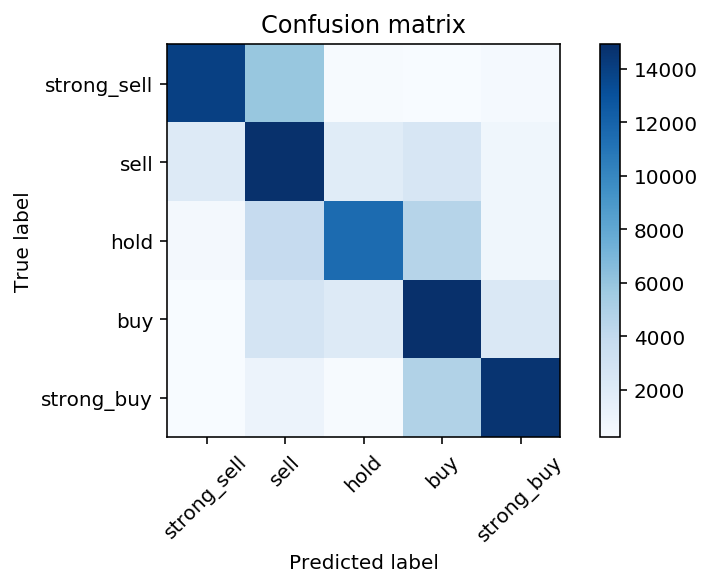

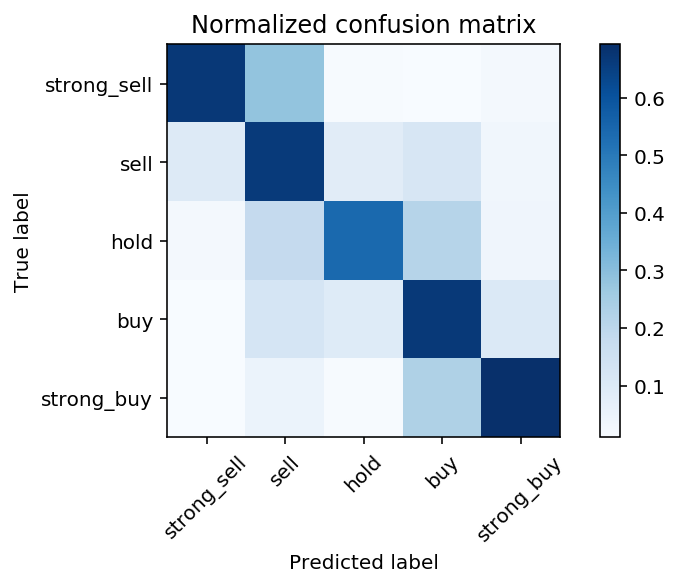

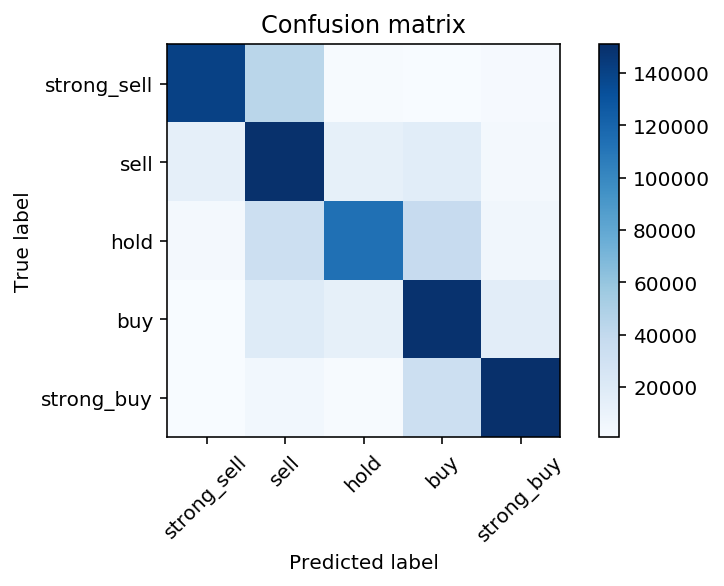

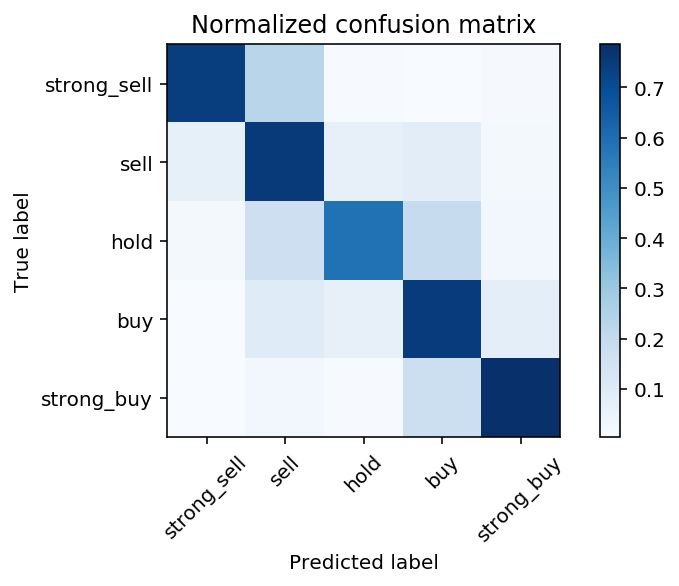

In [74]:
pred_train_y = model.predict(input_list_train)
pred_test_y = model.predict(input_list_test)

train_class_labels = np.argmax(pred_train_y, axis=1)
train_class_vector_one_hot = to_categorical(train_class_labels)
train_class_actuals = np.argmax(y_train, axis=1)

test_class_labels = np.argmax(pred_test_y, axis=1)
test_class_vector_one_hot = to_categorical(test_class_labels)
test_class_actuals = np.argmax(y_test, axis=1)


score_accuracy(train_class_labels, train_class_actuals, test_class_labels, test_class_actuals)

# intermediate_train_vals = intermediate_model.predict(input_list_train)
# intermediate_test_vals = intermediate_model.predict(input_list_test)


# joblib.dump(intermediate_train_vals, '../data/intermediate_train_vals.joblib.z') 
# joblib.dump(intermediate_test_vals, '../data/intermediate_test_vals.joblib.z') 
